# CYGNSS CD: In Situ vs Model Time Series

This notebook loads daily in situ soil moisture from the provided MATLAB archive and compares it against surface (SFMC) and root-zone (RZMC) soil moisture extracted from the control and two DA experiments over a selectable time range (default: 2018-08-01 through 2019-07-31).

In [3]:
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import scipy.io as sio
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Helper typing imports (optional)
from typing import Dict, List, Sequence, Tuple


In [13]:
# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
# MATLAB_FILE = Path('/discover/nobackup/projects/land_da/Evaluation/InSitu/output/OLv8_M36_cd_USCRN_SM_1d_c1234smv_6yr_raw_timeseries.mat')
MATLAB_FILE = Path('/discover/nobackup/projects/land_da/Evaluation/InSitu/output/OLv8_M36_cd_CalVal_M33_SM_1d__6yr_raw_timeseries.mat')

# EXPERIMENTS = {
#     'CNTL': {
#         'cat_dir': Path('/discover/nobackup/projects/land_da/CYGNSS_Experiments/OLv8_M36_cd/OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'),
#         'prefix': 'OLv8_M36_cd'
#     },
#     'DA1': {
#         'cat_dir': Path('/discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_ssa/DAv8_M36_cd_ssa/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'),
#         'prefix': 'DAv8_M36_cd_ssa'
#     },
#     'DA2': {
#         'cat_dir': Path('/discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_ssa_fixed/DAv8_M36_cd_ssa_fixed/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'),
#         'prefix': 'DAv8_M36_cd_ssa_fixed'
#     }
# }

EXPERIMENTS = {
    'CNTL': {
        'cat_dir': Path('/discover/nobackup/projects/land_da/CYGNSS_Experiments/OLv8_M36_cd/OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'),
        'prefix': 'OLv8_M36_cd'
    },
    'DA1': {
        'cat_dir': Path('/discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_a/DAv8_M36_cd_a/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'),
        'prefix': 'DAv8_M36_cd_a'
    },
    'DA2': {
        'cat_dir': Path('/discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_a_fixed/DAv8_M36_cd_a_fixed/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'),
        'prefix': 'DAv8_M36_cd_a_fixed'
    },
    'DA3': {
        'cat_dir': Path('/discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_a_fixed_lowerr/DAv8_M36_cd_a_fixed_lowerr/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'),
        'prefix': 'DAv8_M36_cd_a_fixed_lowerr'
    },
    'DA4': {
        'cat_dir': Path('/discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_a_fixed_v_lowerr/DAv8_M36_cd_a_fixed_v_lowerr/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'),
        'prefix': 'DAv8_M36_cd_a_fixed_v_lowerr'
    }
}

START_DATE = datetime(2018, 8, 1)
END_DATE = datetime(2019, 7, 31)

SURFACE_LAYER_INDEX = 0  # index into second dimension of INSITU_sm
ROOT_LAYER_INDEX = 1     # adjust as needed if different depth mapping
SITE_LIMIT = None        # set to an int to limit the number of stations processed


# Order/labels/styles for plotting
EXPERIMENT_ORDER = ['CNTL', 'DA1', 'DA2', 'DA3', 'DA4']
EXPERIMENT_DISPLAY = {
    'CNTL': 'CNTL',
    'DA1': 'a   9%',
    'DA2': 'a_f 9%',
    'DA3': 'a_f 6.4%',
    'DA4': 'a_f 4.5%',
}
EXPERIMENT_STYLES = {
    'CNTL': '-',
    'DA1': '-',
    'DA2': '--',
    'DA3': ':',
    'DA4': '-.',
}


In [14]:
def unwrap(x):
    while isinstance(x, np.ndarray) and x.size == 1:
        x = x.ravel()[0]
    return x


def load_insitu_timeseries(mat_path: Path) -> Dict[str, np.ndarray]:
    mat = sio.loadmat(mat_path, squeeze_me=False)
    timestamps = []
    dt_array = mat['date_time_vec']
    for entry in dt_array.ravel():
        e = unwrap(entry)
        names = e.dtype.names
        y = int(np.squeeze(e['year'])) if 'year' in names else 0
        mo = int(np.squeeze(e['month'])) if 'month' in names else 1
        d = int(np.squeeze(e['day'])) if 'day' in names else 1
        hr = int(np.squeeze(e['hour'])) if 'hour' in names else 0
        mn = int(np.squeeze(e['min'])) if 'min' in names else 0
        sc = int(np.squeeze(e['sec'])) if 'sec' in names else 0
        timestamps.append(datetime(y, mo, d, hr, mn, sc))

    def decode_ids(raw):
        arr = np.atleast_1d(raw).ravel()
        out = []
        for val in arr:
            v = unwrap(val)
            if isinstance(v, bytes):
                v = v.decode('utf-8', errors='ignore')
            out.append(str(v))
        return out

    def to_float_array(raw):
        if raw is None:
            return None
        arr = np.asarray(raw, dtype=float).squeeze()
        return arr

    return {
        'timestamps': np.array(timestamps),
        'insitu_sm': np.asarray(mat['INSITU_sm']),
        'site_ids': decode_ids(mat.get('INSITU_id')),
        'tile_indices': np.asarray(mat.get('ind_tile')).astype(int).ravel(),
        'lats': to_float_array(mat.get('INSITU_lat')),
        'lons': to_float_array(mat.get('INSITU_lon'))
    }


def daterange(start: datetime, end: datetime) -> List[datetime]:
    days = []
    cur = start
    while cur <= end:
        days.append(cur)
        cur += timedelta(days=1)
    return days


def build_daily_file(cat_dir: Path, prefix: str, day: datetime) -> Path:
    return cat_dir / f"Y{day.year:04d}" / f"M{day.month:02d}" / f"{prefix}.tavg24_1d_lnd_Nt.{day:%Y%m%d}_1200z.nc4"


def fetch_model_series(cat_dir: Path, prefix: str, tile_indices: Sequence[int], days: Sequence[datetime],
                       variables: Sequence[str] = ('SFMC', 'RZMC'), fill_value: float = np.nan) -> Dict[str, np.ndarray]:
    zero_idx = np.asarray(tile_indices, dtype=int) - 1
    n_days = len(days)
    n_sites = len(zero_idx)
    out = {var: np.full((n_days, n_sites), fill_value, dtype=float) for var in variables}

    for i, day in enumerate(days):
        nc_path = build_daily_file(cat_dir, prefix, day)
        if not nc_path.exists():
            print(f"Missing file for {day:%Y-%m-%d}: {nc_path}")
            continue
        with Dataset(nc_path) as nc:
            for var in variables:
                if var not in nc.variables:
                    print(f"Variable {var} not found in {nc_path.name}")
                    continue
                row = nc.variables[var][0, zero_idx]
                data = np.array(row, dtype=float)
                if np.ma.is_masked(row):
                    data = np.where(row.mask, fill_value, row.filled(fill_value))
                out[var][i, :] = data
    return out


def extract_insitu_layer(insitu_array: np.ndarray, timestamps: np.ndarray, days: Sequence[datetime],
                         layer_index: int, site_slice: slice = slice(None)) -> np.ndarray:
    day_map = {}
    for idx, ts in enumerate(timestamps):
        day_map.setdefault(ts.date(), idx)
    selected = insitu_array[:, layer_index, :]
    selected = selected[:, site_slice]
    result = np.full((len(days), selected.shape[1]), np.nan, dtype=float)
    for i, day in enumerate(days):
        idx = day_map.get(day.date())
        if idx is None:
            continue
        result[i, :] = selected[idx, :]
    return result


In [7]:
# -----------------------------------------------------------------------------
# Load in situ data
# -----------------------------------------------------------------------------
insitu = load_insitu_timeseries(MATLAB_FILE)
print('Loaded stations:', len(insitu['site_ids']))

# Optionally limit the number of stations for quick-look plots
if SITE_LIMIT is not None:
    site_slice = slice(0, SITE_LIMIT)
else:
    site_slice = slice(None)

date_list = daterange(START_DATE, END_DATE)
tile_indices = insitu['tile_indices'][site_slice]
site_ids = insitu['site_ids'][site_slice]
site_lats = insitu['lats'][site_slice]
site_lons = insitu['lons'][site_slice]

insitu_surface = extract_insitu_layer(insitu['insitu_sm'], insitu['timestamps'], date_list,
                                      SURFACE_LAYER_INDEX, site_slice)
insitu_root = extract_insitu_layer(insitu['insitu_sm'], insitu['timestamps'], date_list,
                                   ROOT_LAYER_INDEX, site_slice)
print('In situ arrays shape:', insitu_surface.shape)


Loaded stations: 11
In situ arrays shape: (365, 11)


In [8]:
# -----------------------------------------------------------------------------
# Load model series for each experiment
# -----------------------------------------------------------------------------
model_data = {}
for label, cfg in EXPERIMENTS.items():
    print(f"Reading {label} from {cfg['cat_dir']}")
    model_data[label] = fetch_model_series(cfg['cat_dir'], cfg['prefix'], tile_indices, date_list)

print({label: {var: arr.shape for var, arr in data.items()} for label, data in model_data.items()})


Reading CNTL from /discover/nobackup/projects/land_da/CYGNSS_Experiments/OLv8_M36_cd/OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg
Reading DA1 from /discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_a/DAv8_M36_cd_a/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg
Reading DA2 from /discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_a_fixed/DAv8_M36_cd_a_fixed/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg
Reading DA3 from /discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_a_fixed_lowerr/DAv8_M36_cd_a_fixed_lowerr/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg
Reading DA4 from /discover/nobackup/projects/land_da/CYGNSS_Experiments/DAv8_M36_cd_a_fixed_v_lowerr/DAv8_M36_cd_a_fixed_v_lowerr/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg
{'CNTL': {'SFMC': (365, 11), 'RZMC': (365, 11)}, 'DA1': {'SFMC': (365, 11), 'RZMC': (365, 11)}, 'DA2': {'SFMC': (365, 11), 'RZMC': (365, 11)}, 'DA3': {'SFMC': (365, 11), 'RZMC': (365, 11)}, 'DA4': {'SFMC': (365, 11), 'RZMC': 

In [15]:
# -----------------------------------------------------------------------------
# Plot helper
# -----------------------------------------------------------------------------
def _to_datetime64(value):
    if value is None:
        return None
    if isinstance(value, str):
        return np.datetime64(value)
    return np.datetime64(value)


def plot_site_timeseries(site_idx: int, start=None, end=None):
    if site_idx < 0 or site_idx >= len(site_ids):
        raise IndexError('site_idx out of range')

    dates = np.array(date_list)
    dates64 = np.array([np.datetime64(dt) for dt in date_list])
    start_dt = _to_datetime64(start)
    end_dt = _to_datetime64(end)
    mask = np.ones(dates64.shape, dtype=bool)
    if start_dt is not None:
        mask &= dates64 >= start_dt
    if end_dt is not None:
        mask &= dates64 <= end_dt
    if not mask.any():
        raise ValueError('No dates fall within the specified range')
    idx = np.where(mask)[0]
    sel_dates = dates[idx]

    available_experiments = [exp for exp in EXPERIMENT_ORDER if exp in model_data]
    if not available_experiments:
        raise ValueError('No experiments available for plotting')

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Surface
    axes[0].plot(sel_dates, insitu_surface[idx, site_idx], label='INSITU', linewidth=2)
    for exp in available_experiments:
        axes[0].plot(
            sel_dates,
            model_data[exp]['SFMC'][idx, site_idx],
            label=EXPERIMENT_DISPLAY.get(exp, exp),
            linestyle=EXPERIMENT_STYLES.get(exp, '-')
        )
    axes[0].set_ylabel('Surface SM (m3/m3)')
    axes[0].set_title(f'Surface soil moisture comparison (Site {site_ids[site_idx]})')
    axes[0].grid(True, linestyle=':')
    axes[0].legend()

    # Rootzone
    axes[1].plot(sel_dates, insitu_root[idx, site_idx], label='INSITU', linewidth=2)
    for exp in available_experiments:
        axes[1].plot(
            sel_dates,
            model_data[exp]['RZMC'][idx, site_idx],
            label=EXPERIMENT_DISPLAY.get(exp, exp),
            linestyle=EXPERIMENT_STYLES.get(exp, '-')
        )
    axes[1].set_ylabel('Root-zone SM (m3/m3)')
    axes[1].set_title('Root-zone soil moisture comparison')
    axes[1].grid(True, linestyle=':')
    axes[1].legend()

    axes[1].xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_dir = Path('plots')
    save_dir.mkdir(parents=True, exist_ok=True)
    start_tag = f"_{start_dt.astype('datetime64[D]')}" if start_dt is not None else ''
    end_tag = f"_{end_dt.astype('datetime64[D]')}" if end_dt is not None else ''
    fname = save_dir / f"site_{site_idx}_{site_ids[site_idx]}{start_tag}{end_tag}.png"
    fig.savefig(fname, dpi=150, bbox_inches='tight')
    print(f"Saved plot to {fname}")
    plt.show()

print('Use plot_site_timeseries(site_idx, start=None, end=None) to visualize a station (0-indexed).')


Use plot_site_timeseries(site_idx, start=None, end=None) to visualize a station (0-indexed).


Plotting site 0: 07013301
Saved plot to plots/site_0_07013301.png


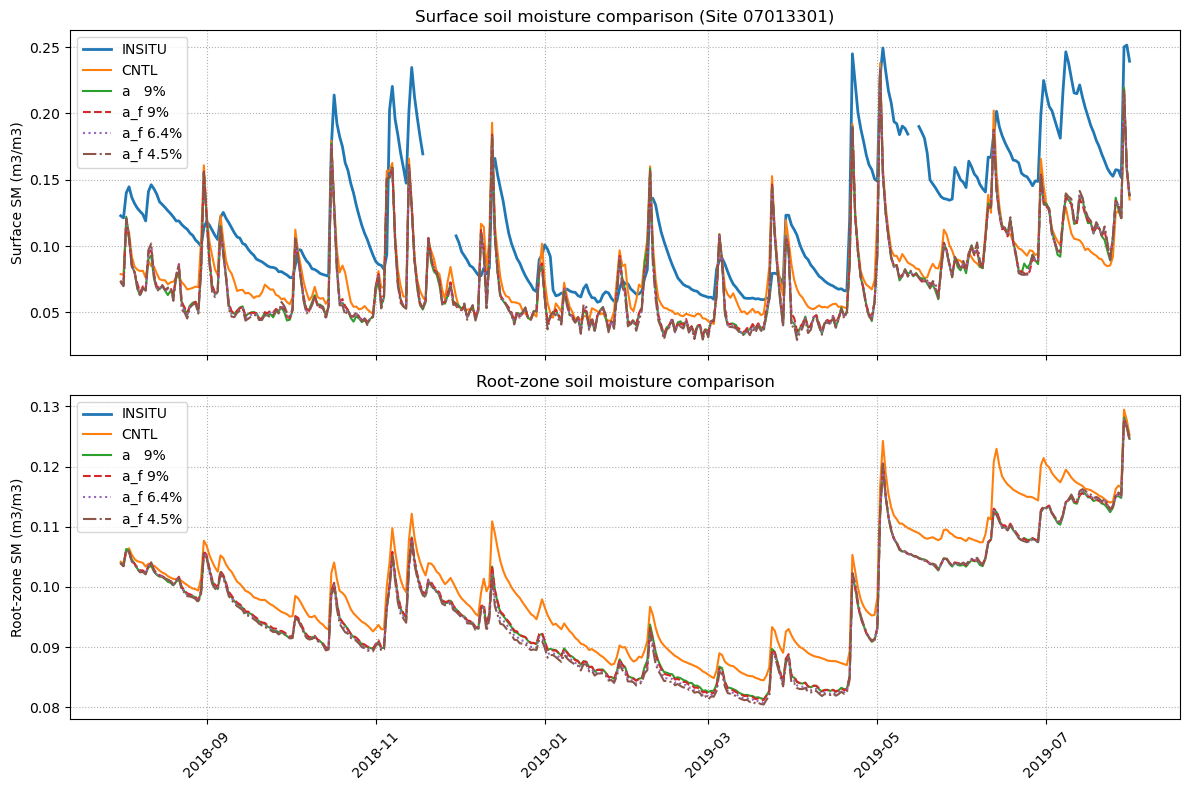

Plotting site 1: 12033301
Saved plot to plots/site_1_12033301.png


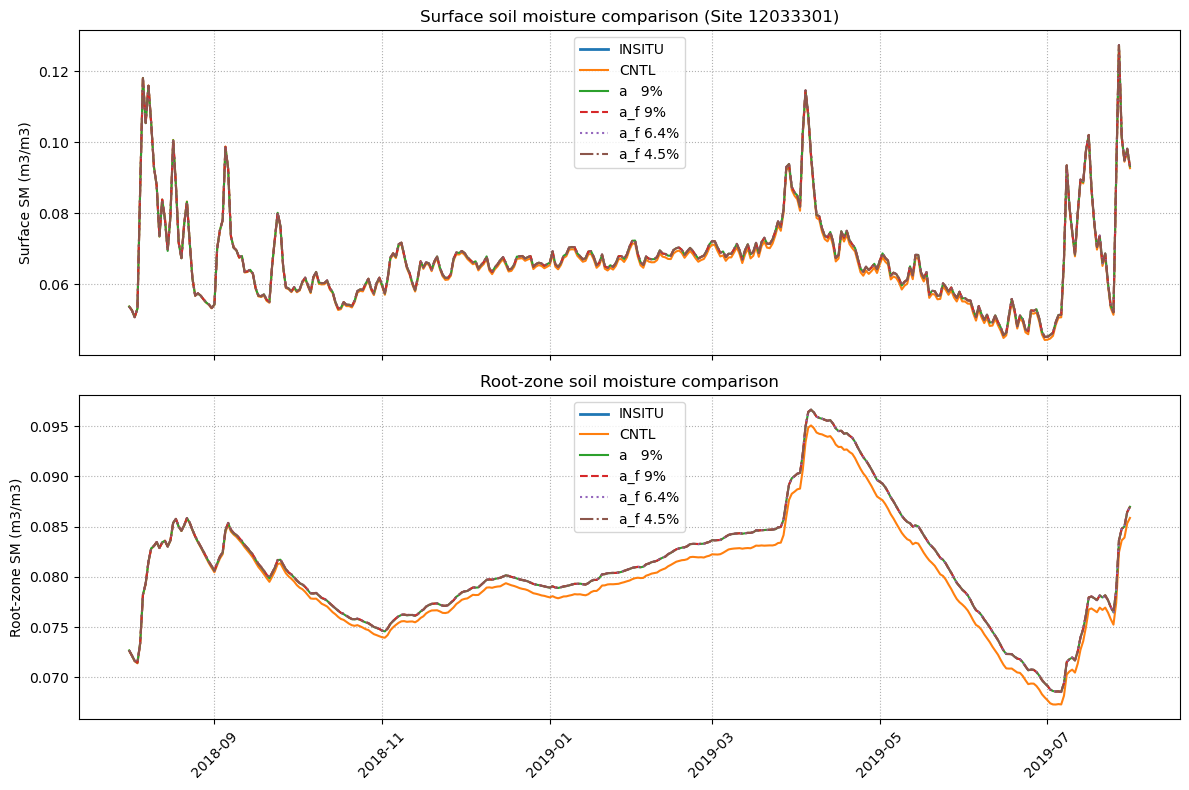

Plotting site 2: 16013302
Saved plot to plots/site_2_16013302.png


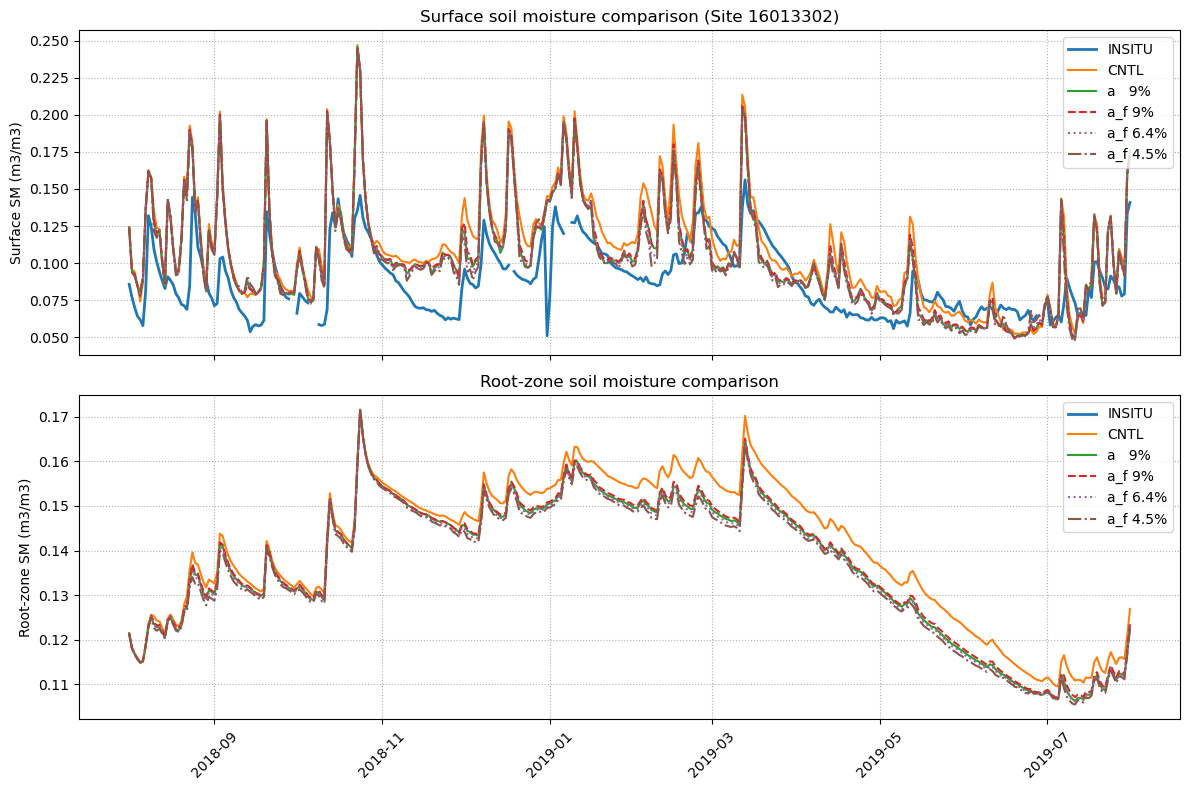

Plotting site 3: 16023302
Saved plot to plots/site_3_16023302.png


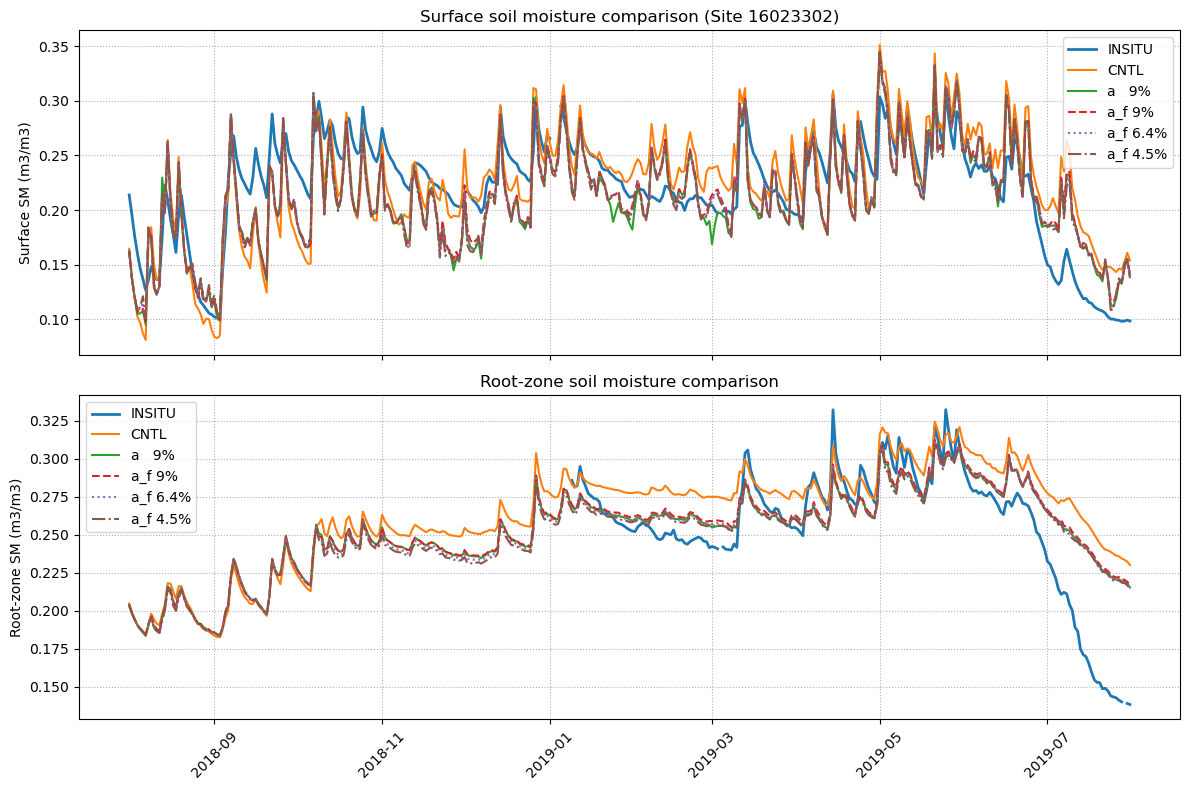

Plotting site 4: 16033302
Saved plot to plots/site_4_16033302.png


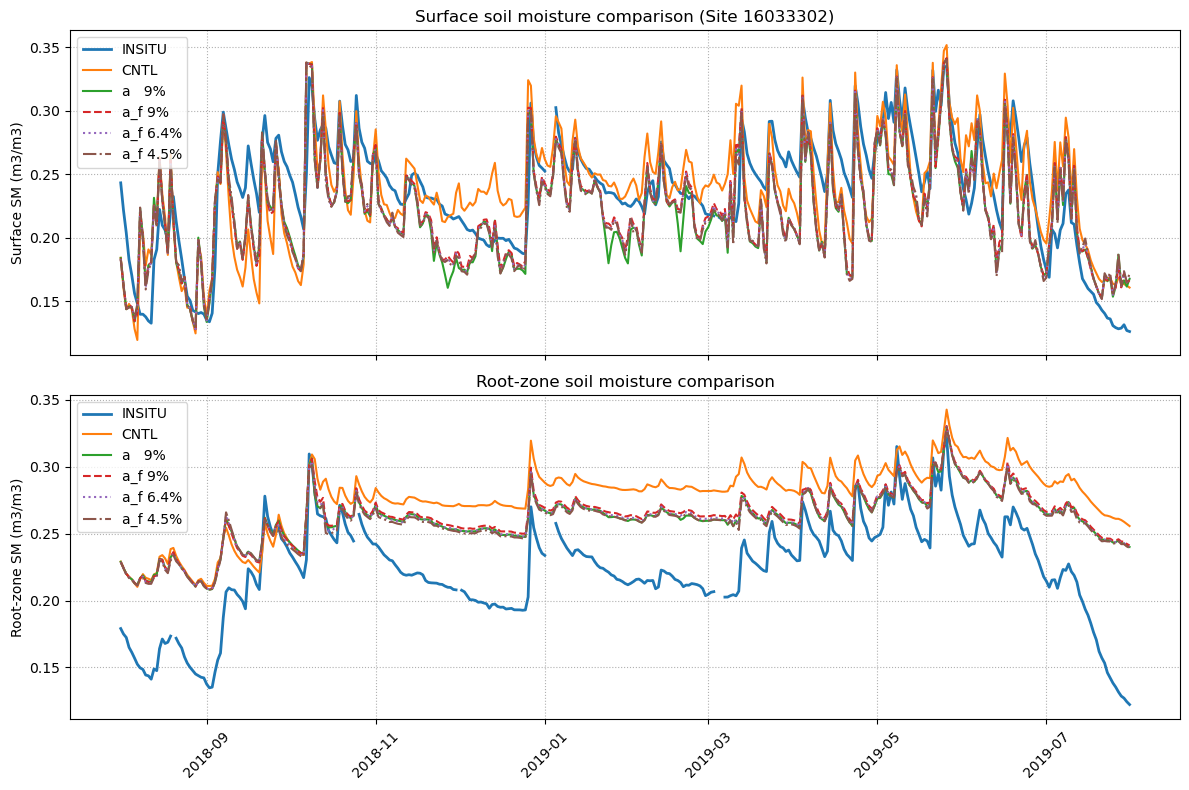

Plotting site 5: 16043302
Saved plot to plots/site_5_16043302.png


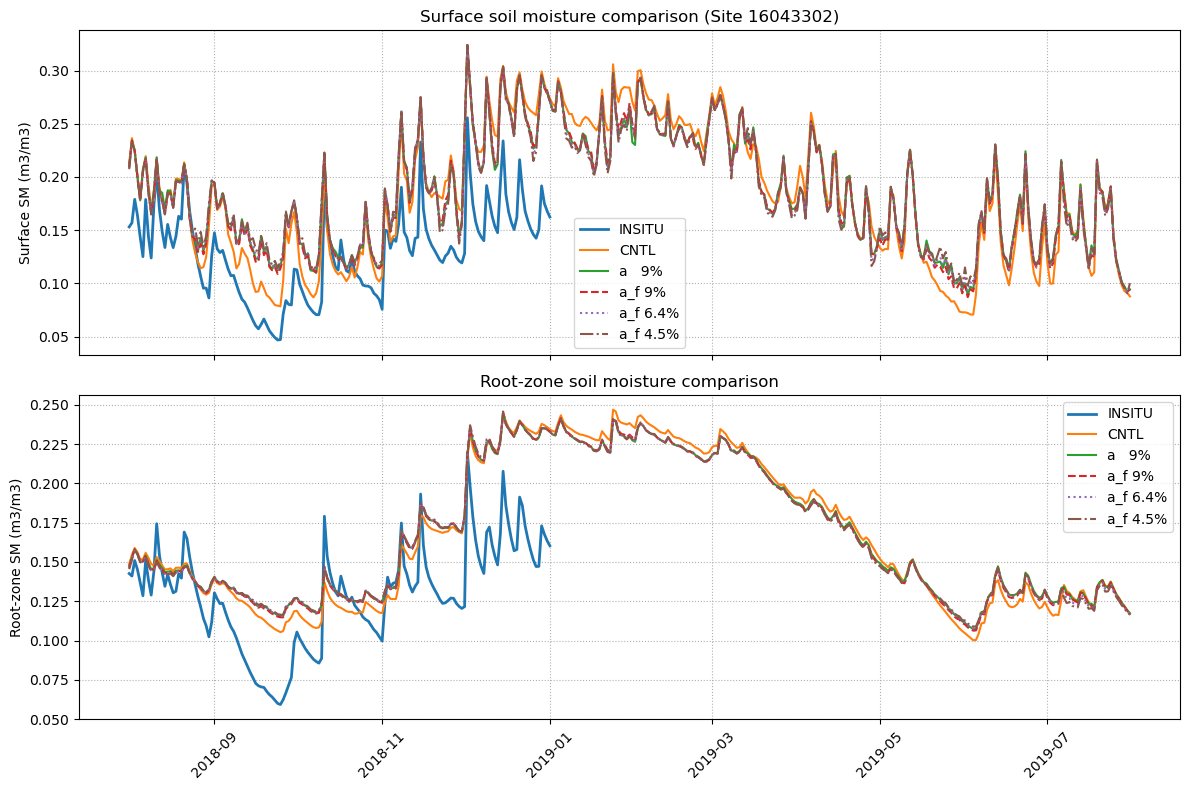

Plotting site 6: 19023301
Saved plot to plots/site_6_19023301.png


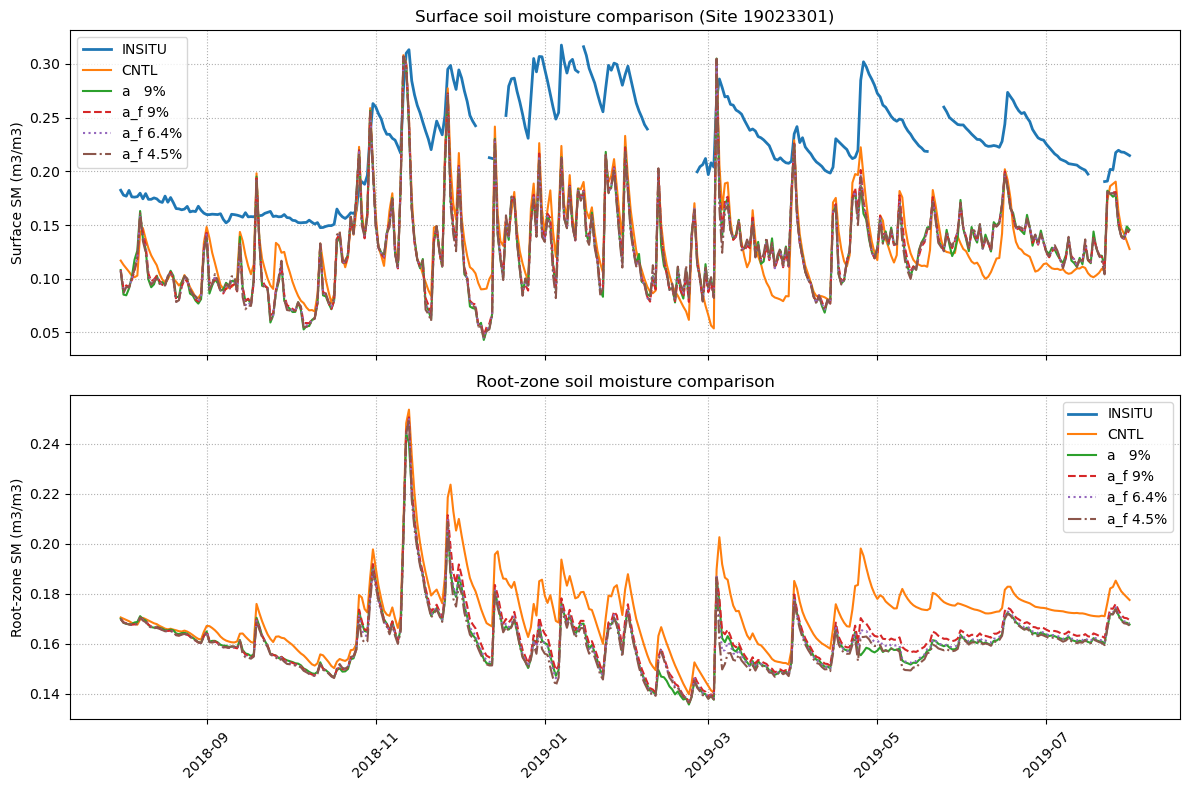

Plotting site 7: 25013301
Saved plot to plots/site_7_25013301.png


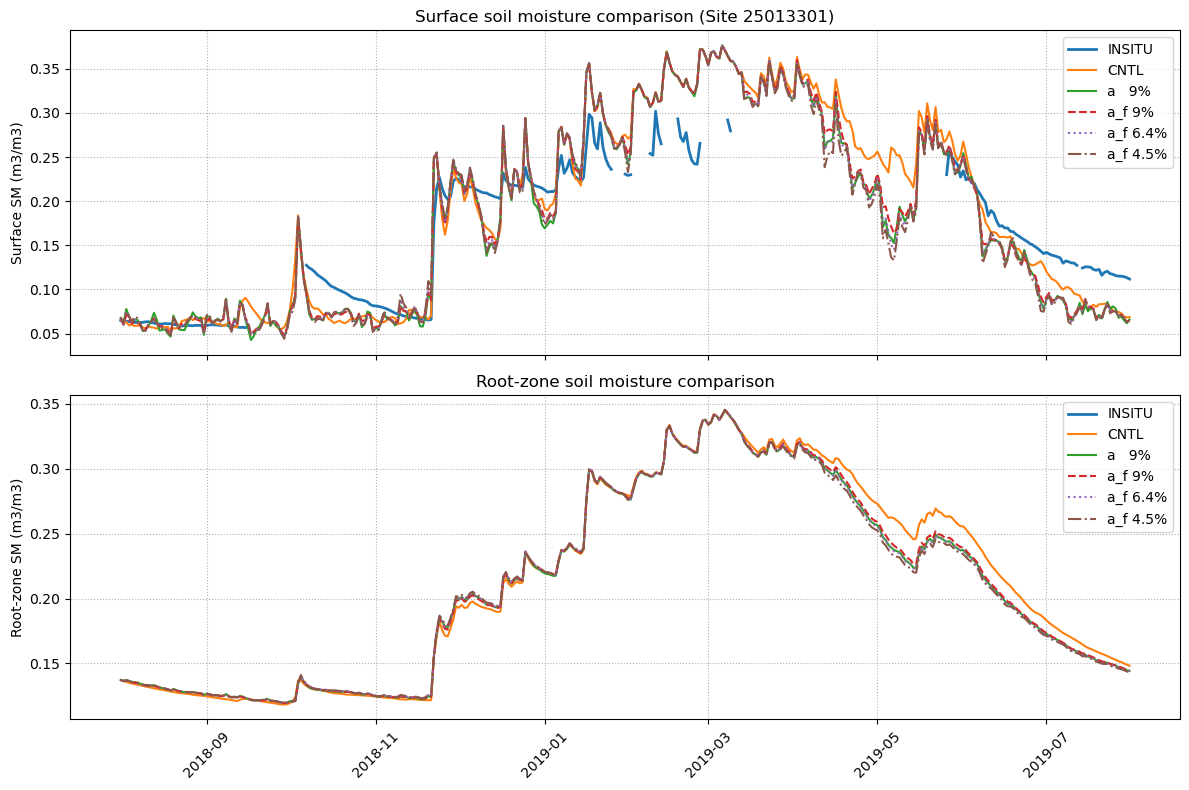

Plotting site 8: 45013301
Saved plot to plots/site_8_45013301.png


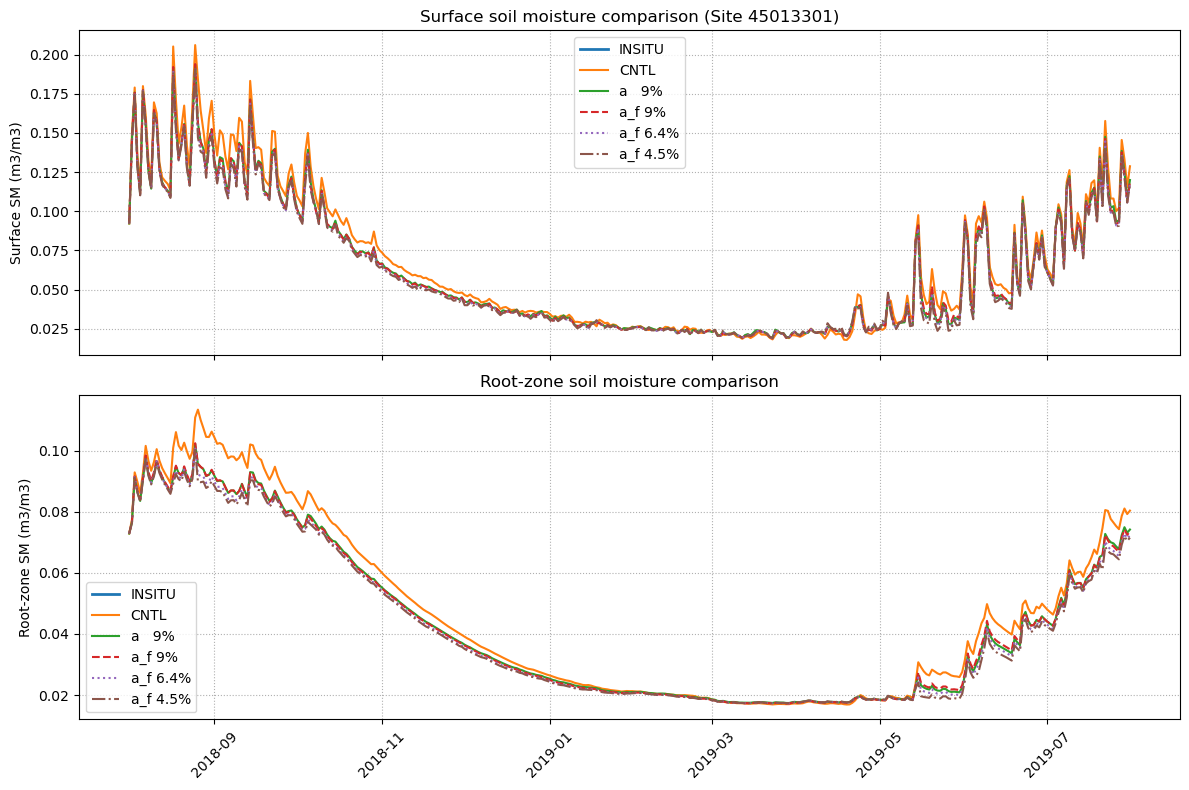

Plotting site 9: 45023301
Saved plot to plots/site_9_45023301.png


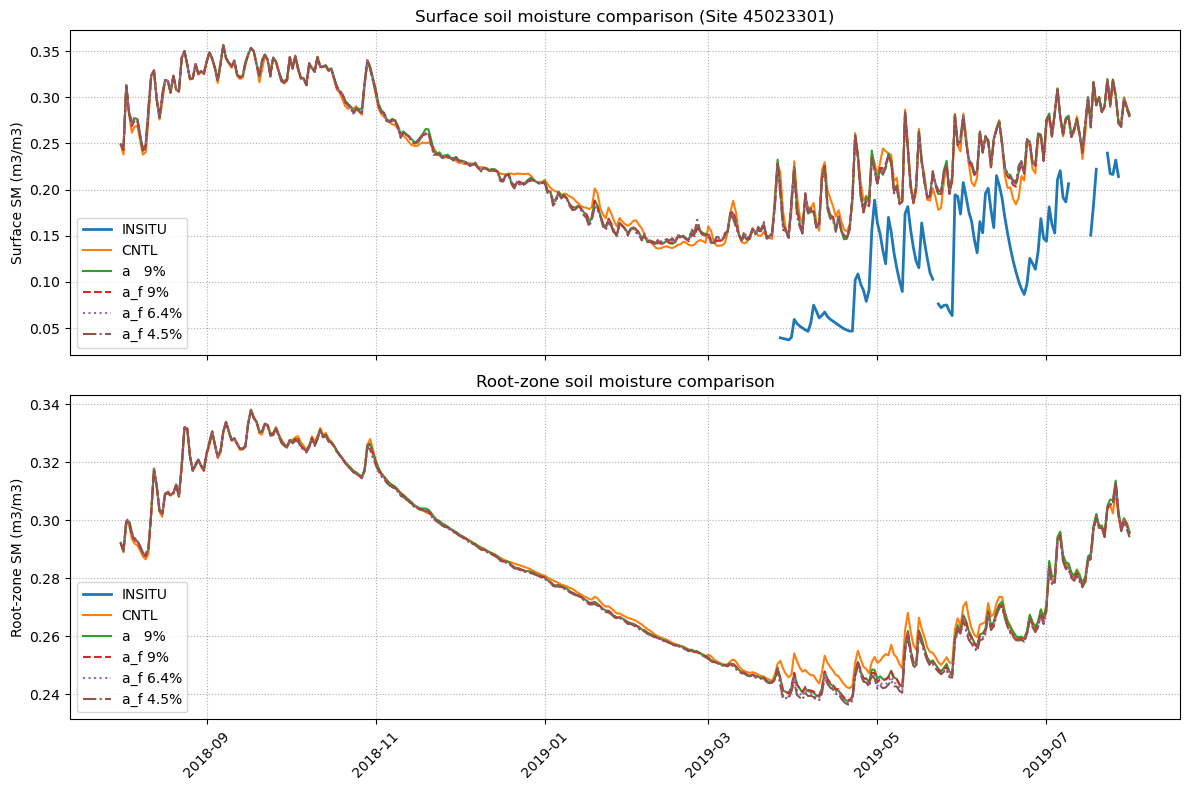

In [20]:
n_plot = min(10, len(site_ids))
for idx in range(n_plot):
    print(f"Plotting site {idx}: {site_ids[idx]}")
    plot_site_timeseries(idx)
    plt.show()

Plotting site 0: 07013301
Saved plot to plots/site_0_07013301_2019-05-01_2021-07-01.png


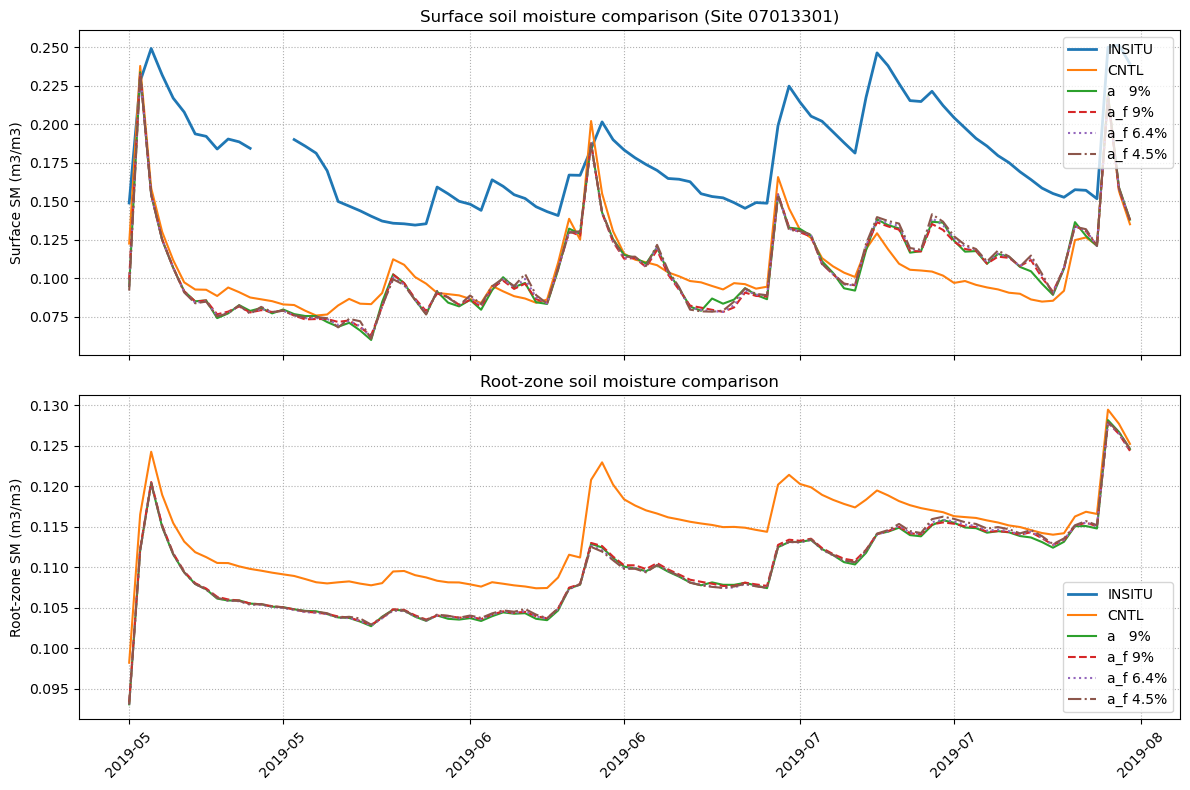

Plotting site 1: 12033301
Saved plot to plots/site_1_12033301_2019-05-01_2021-07-01.png


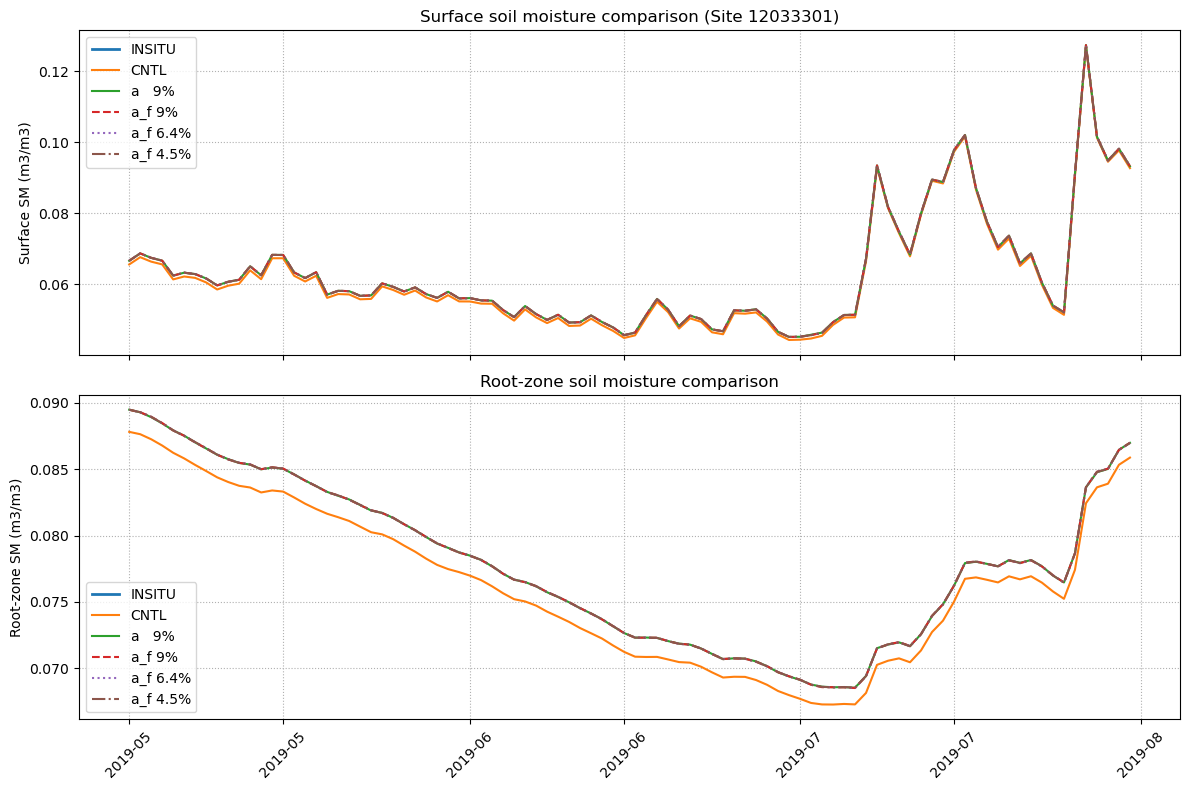

Plotting site 2: 16013302
Saved plot to plots/site_2_16013302_2019-05-01_2021-07-01.png


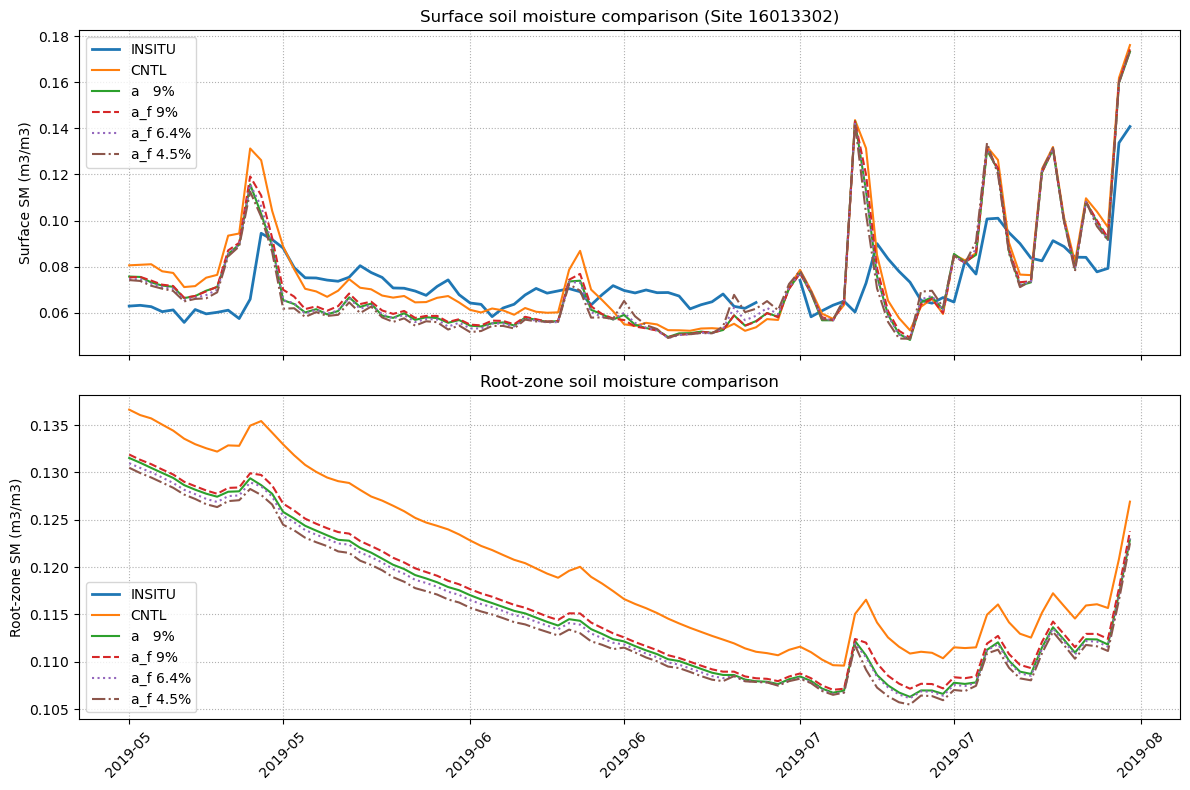

Plotting site 3: 16023302
Saved plot to plots/site_3_16023302_2019-05-01_2021-07-01.png


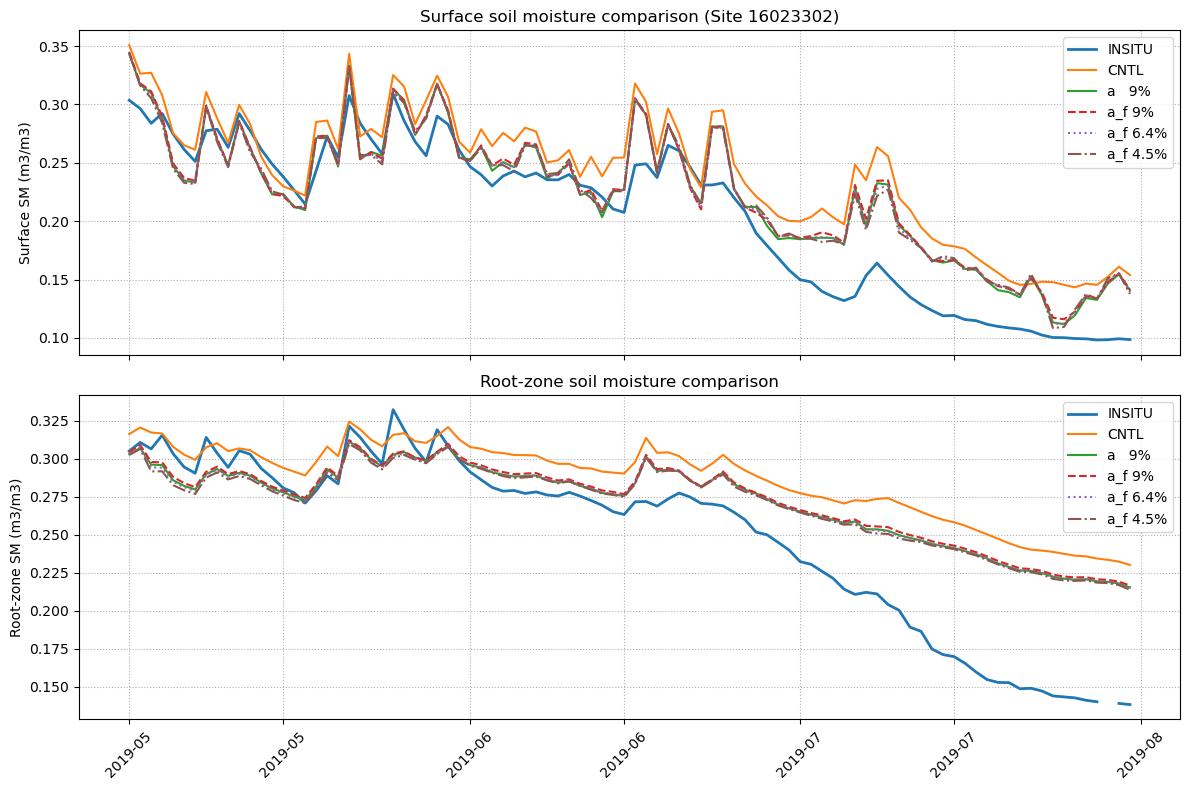

Plotting site 4: 16033302
Saved plot to plots/site_4_16033302_2019-05-01_2021-07-01.png


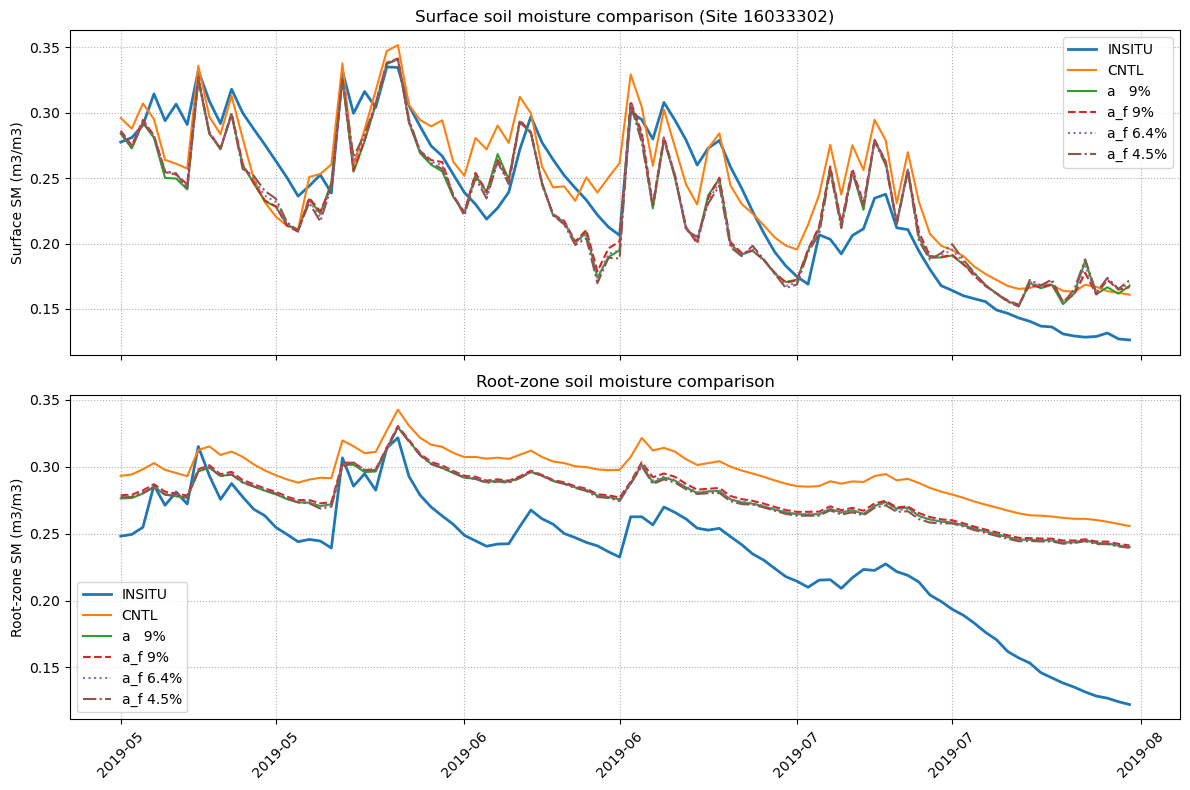

Plotting site 5: 16043302
Saved plot to plots/site_5_16043302_2019-05-01_2021-07-01.png


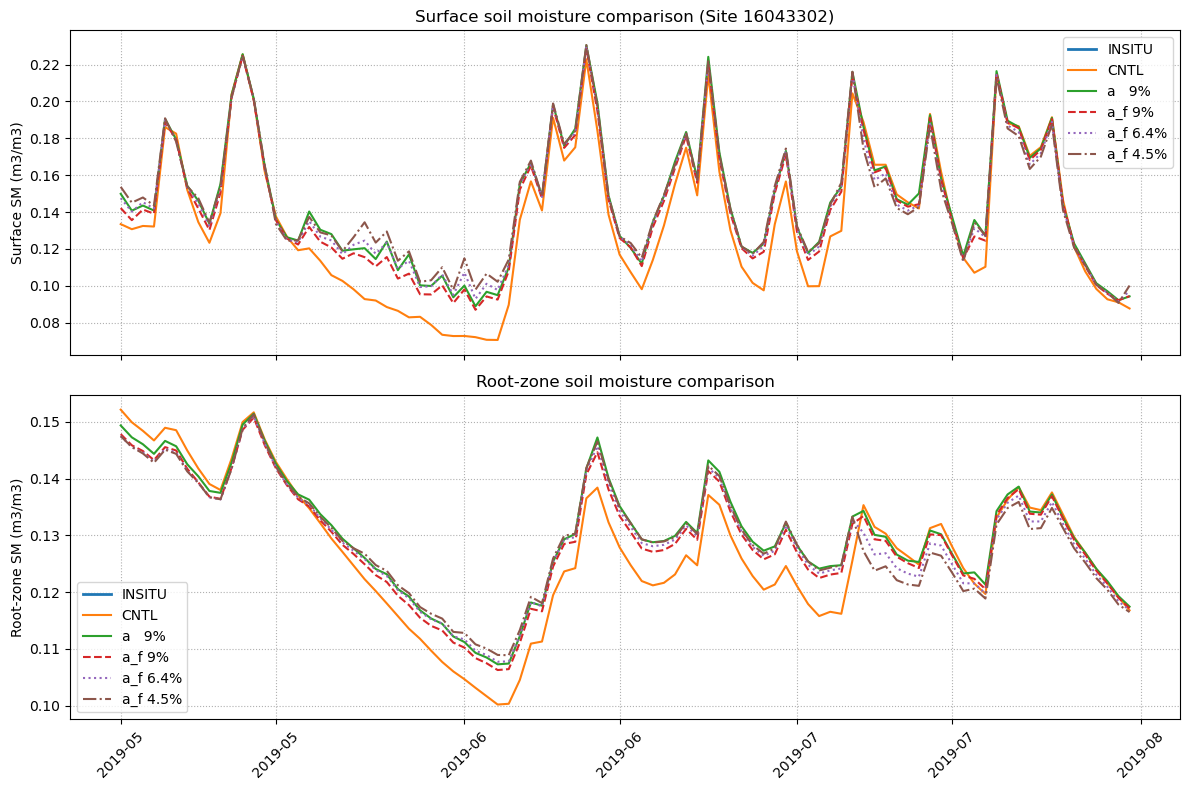

Plotting site 6: 19023301
Saved plot to plots/site_6_19023301_2019-05-01_2021-07-01.png


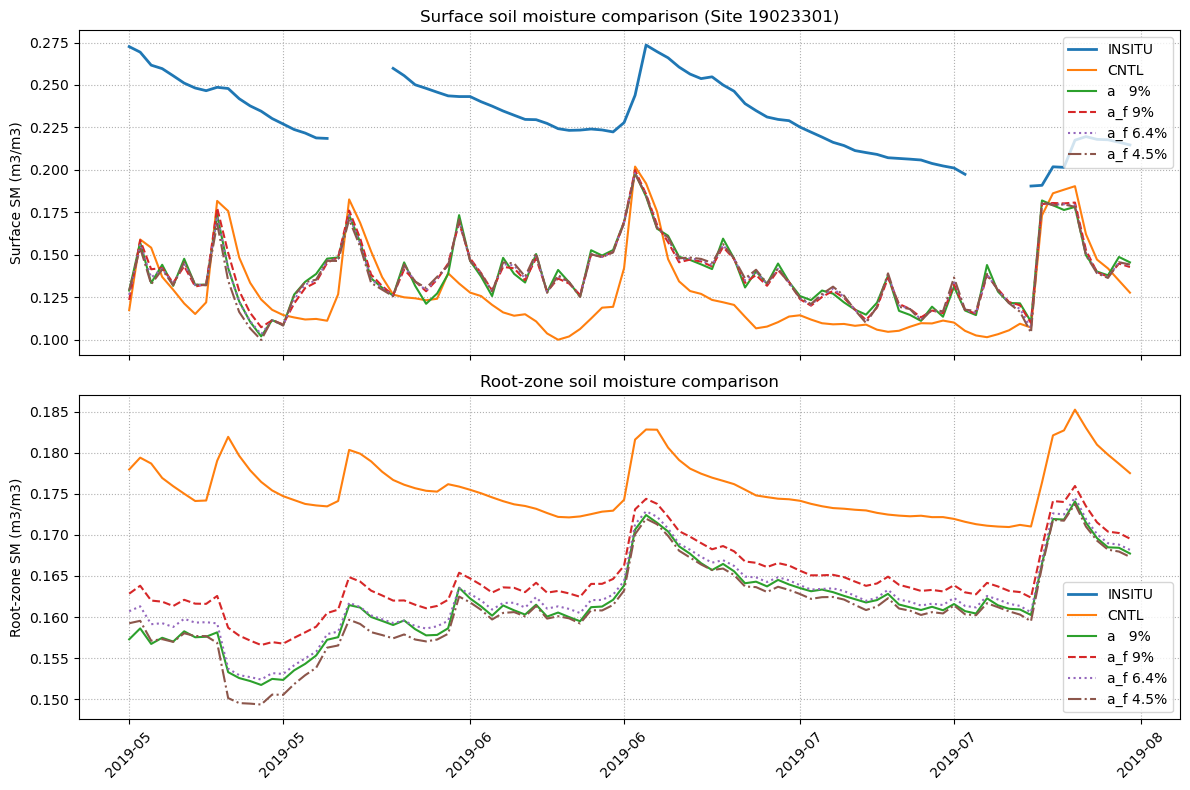

Plotting site 7: 25013301
Saved plot to plots/site_7_25013301_2019-05-01_2021-07-01.png


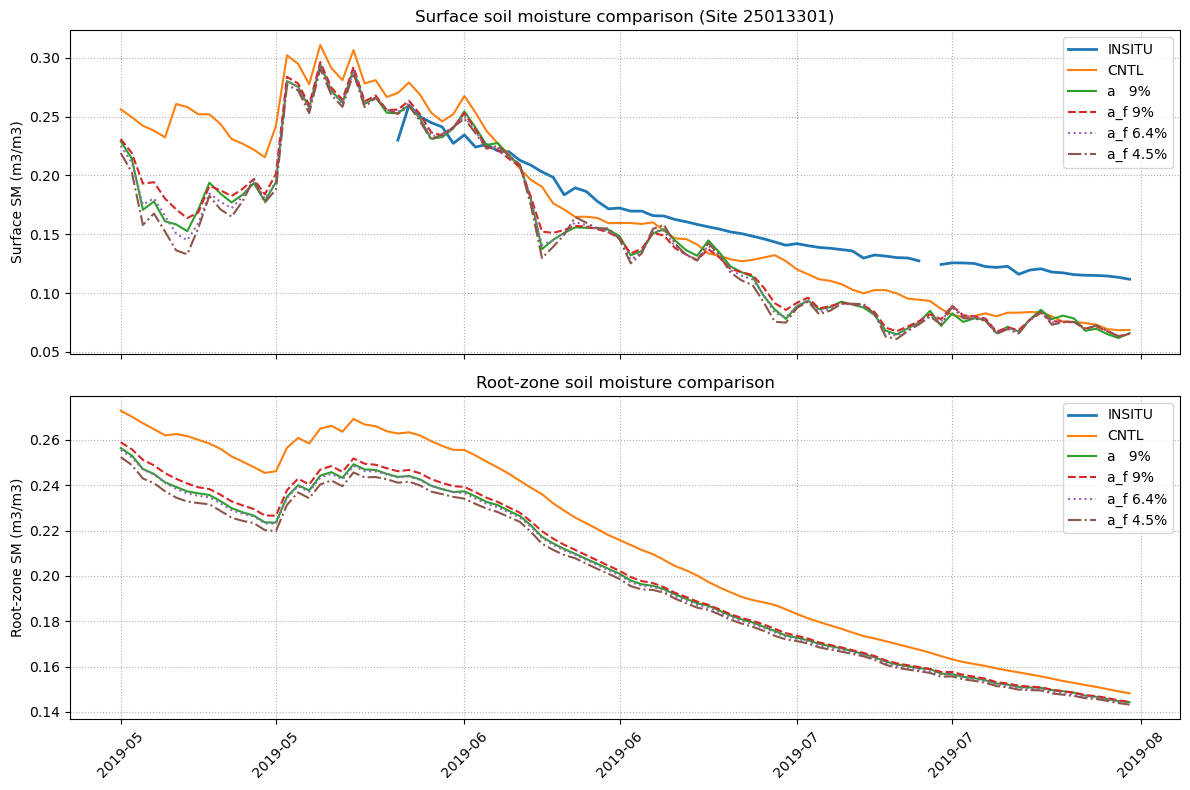

Plotting site 8: 45013301
Saved plot to plots/site_8_45013301_2019-05-01_2021-07-01.png


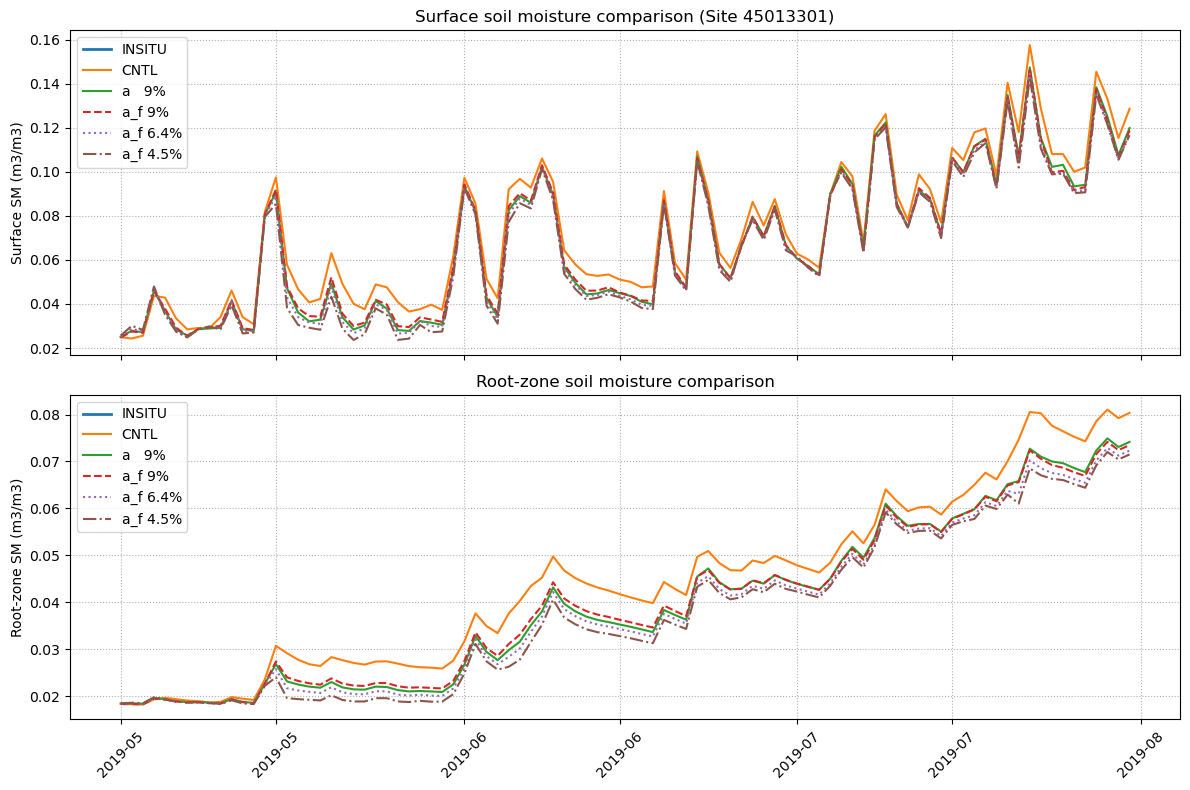

Plotting site 9: 45023301
Saved plot to plots/site_9_45023301_2019-05-01_2021-07-01.png


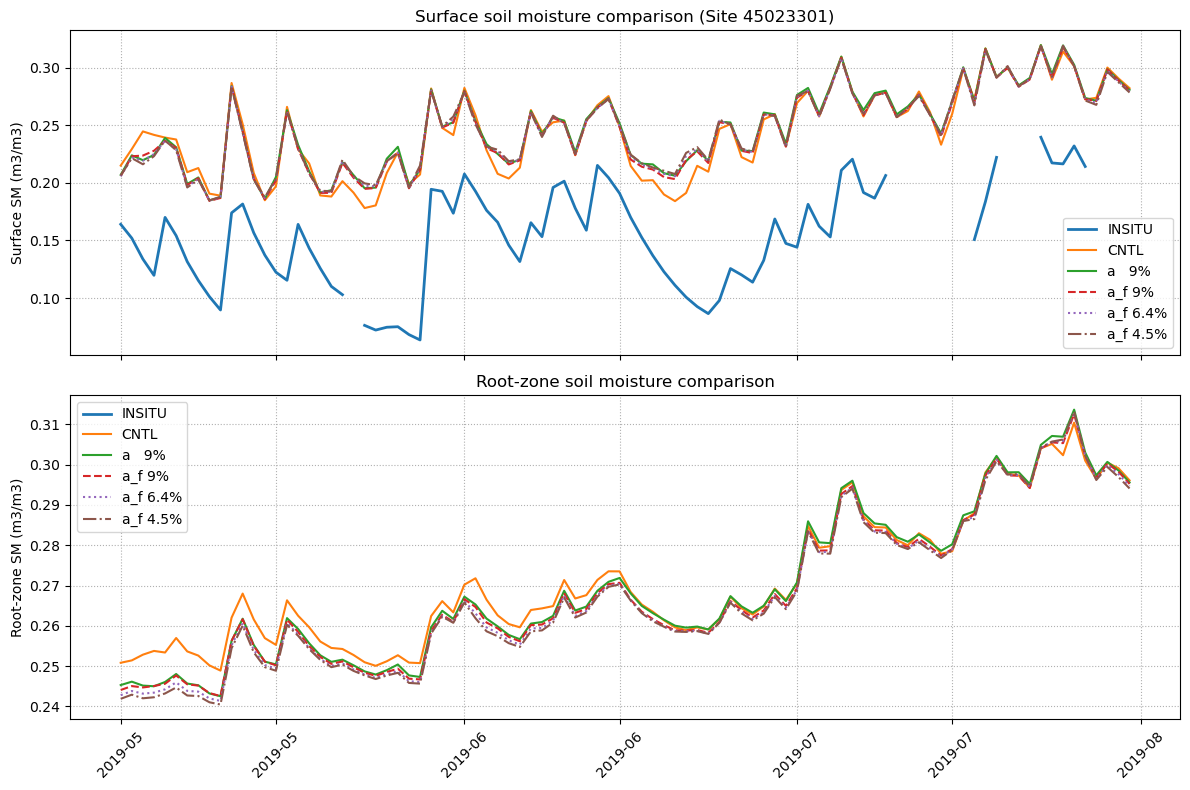

In [21]:
n_plot = min(10, len(site_ids))
for idx in range(n_plot):
    print(f"Plotting site {idx}: {site_ids[idx]}")
    plot_site_timeseries(idx,start='2019-05-01',end='2021-07-01')
    plt.show()

In [22]:
import json
import numpy as np

save_path = Path('insitu_vs_model_timeseries.npz')
np.savez(
    save_path,
    dates=np.array([dt.strftime('%Y-%m-%d') for dt in date_list]),
    site_ids=np.array(site_ids),
    site_lats=site_lats,
    site_lons=site_lons,
    insitu_surface=insitu_surface,
    insitu_root=insitu_root,
    cntl_sfmc=model_data['CNTL']['SFMC'],
    da1_sfmc=model_data['DA1']['SFMC'],
    da2_sfmc=model_data['DA2']['SFMC'],
    cntl_rzmc=model_data['CNTL']['RZMC'],
    da1_rzmc=model_data['DA1']['RZMC'],
    da2_rzmc=model_data['DA2']['RZMC'],
)
print('Saved combined time series to', save_path)


Saved combined time series to insitu_vs_model_timeseries.npz
